# Make Masks
Let's make some masks for the testing set so we can use them for evaluation of lesion level metrics.

In [1]:
from pathlib import Path

import numpy as np

from PIL import Image

from repath.utils.convert import np_to_pil
from repath.data.annotations.asapxml import load_annotations
from repath.data.slides.openslide import Slide

In [2]:
from repath.data.annotations import AnnotationSet

def load_camelyon16_annotations(file: Path) -> AnnotationSet:
    group_labels = {"Tumor": "tumor", "_0": "tumor", "_1": 'tumor', "_2": 'normal', 'Exclusion': 'normal', 'None': 'normal'}
    annotations = load_annotations(file, group_labels) if file else []
    labels_order = ["background", "tumor", "normal"]
    return AnnotationSet(annotations, {"background": 0, "normal": 1, "tumor": 2}, labels_order, "normal")

In [3]:
def make_mask(src_path: Path, dest_path: Path, annotations_path: Path, level: int) -> None:
    annotations = load_camelyon16_annotations(annotations_path)
    labels_order = ["background", "tumor", "normal"]
    annotations = sorted(annotations.annotations, key=lambda a: labels_order.index(a.label))
    
    with Slide(src_path) as slide:
        shape = slide.dimensions[level].as_shape()
        mask = np.full(shape, 0, dtype=np.uint8)
        tumor_idx = 1
        for annotation in annotations:                
            annotation.draw(mask, {"background": 0, "normal": 0, "tumor": tumor_idx}, 2**level)
            if annotation.label == "tumor":
                tumor_idx = tumor_idx + 1
        mask_img = Image.fromarray(mask)
        mask_img.save(dest_path)
        print(f"Saved {str(dest_path)}, max: {np.max(mask)}")

In [4]:
# make testing masks
from repath.utils.paths import project_root

level = 5

testing_root = project_root() / 'data' / 'camelyon16' / 'raw' / 'testing'
annot_paths = sorted(list((testing_root / 'lesion_annotations').glob("*.xml")))

# create input paths for the slides that have annotations
slides_root = testing_root / 'images'
slide_paths = sorted([slides_root / (p.stem + ".tif") for p in annot_paths])

# create the output directory
output_dir = project_root() / 'experiments' / 'masks' / 'camelyon16' / 'testing'
output_dir.mkdir(parents=True, exist_ok=True)
output_paths = sorted([output_dir / (p.stem + ".png") for p in annot_paths])

paths = list(zip(slide_paths, output_paths, annot_paths))
for slide_path, output_path, annot_path in paths:
    make_mask(slide_path, output_path, annot_path, level)

Saved /home/ubuntu/repath/experiments/masks/camelyon16/testing/test_001.png, max: 30
Saved /home/ubuntu/repath/experiments/masks/camelyon16/testing/test_002.png, max: 23
Saved /home/ubuntu/repath/experiments/masks/camelyon16/testing/test_004.png, max: 3
Saved /home/ubuntu/repath/experiments/masks/camelyon16/testing/test_008.png, max: 7
Saved /home/ubuntu/repath/experiments/masks/camelyon16/testing/test_010.png, max: 2
Saved /home/ubuntu/repath/experiments/masks/camelyon16/testing/test_011.png, max: 9
Saved /home/ubuntu/repath/experiments/masks/camelyon16/testing/test_013.png, max: 2
Saved /home/ubuntu/repath/experiments/masks/camelyon16/testing/test_016.png, max: 51
Saved /home/ubuntu/repath/experiments/masks/camelyon16/testing/test_021.png, max: 25
Saved /home/ubuntu/repath/experiments/masks/camelyon16/testing/test_026.png, max: 255
Saved /home/ubuntu/repath/experiments/masks/camelyon16/testing/test_027.png, max: 1
Saved /home/ubuntu/repath/experiments/masks/camelyon16/testing/test_02

In [5]:
# make testing masks
from repath.utils.paths import project_root

level = 5

testing_root = project_root() / 'data' / 'camelyon16' / 'raw' / 'training'
annot_paths = sorted(list((testing_root / 'lesion_annotations').glob("*.xml")))

# create input paths for the slides that have annotations
slides_root = testing_root / 'tumor'
slide_paths = sorted([slides_root / (p.stem + ".tif") for p in annot_paths])

# create the output directory
output_dir = project_root() / 'experiments' / 'masks' / 'camelyon16' / 'training'
output_dir.mkdir(parents=True, exist_ok=True)
output_paths = sorted([output_dir / (p.stem + ".png") for p in annot_paths])

paths = list(zip(slide_paths, output_paths, annot_paths))
for slide_path, output_path, annot_path in paths:
    make_mask(slide_path, output_path, annot_path, level)

Saved /home/ubuntu/repath/experiments/masks/camelyon16/training/tumor_001.png, max: 2
Saved /home/ubuntu/repath/experiments/masks/camelyon16/training/tumor_002.png, max: 1
Saved /home/ubuntu/repath/experiments/masks/camelyon16/training/tumor_003.png, max: 13
Saved /home/ubuntu/repath/experiments/masks/camelyon16/training/tumor_004.png, max: 7
Saved /home/ubuntu/repath/experiments/masks/camelyon16/training/tumor_005.png, max: 4
Saved /home/ubuntu/repath/experiments/masks/camelyon16/training/tumor_006.png, max: 5
Saved /home/ubuntu/repath/experiments/masks/camelyon16/training/tumor_007.png, max: 8
Saved /home/ubuntu/repath/experiments/masks/camelyon16/training/tumor_008.png, max: 7
Saved /home/ubuntu/repath/experiments/masks/camelyon16/training/tumor_009.png, max: 6
Saved /home/ubuntu/repath/experiments/masks/camelyon16/training/tumor_010.png, max: 3
Saved /home/ubuntu/repath/experiments/masks/camelyon16/training/tumor_011.png, max: 63
Saved /home/ubuntu/repath/experiments/masks/camelyon

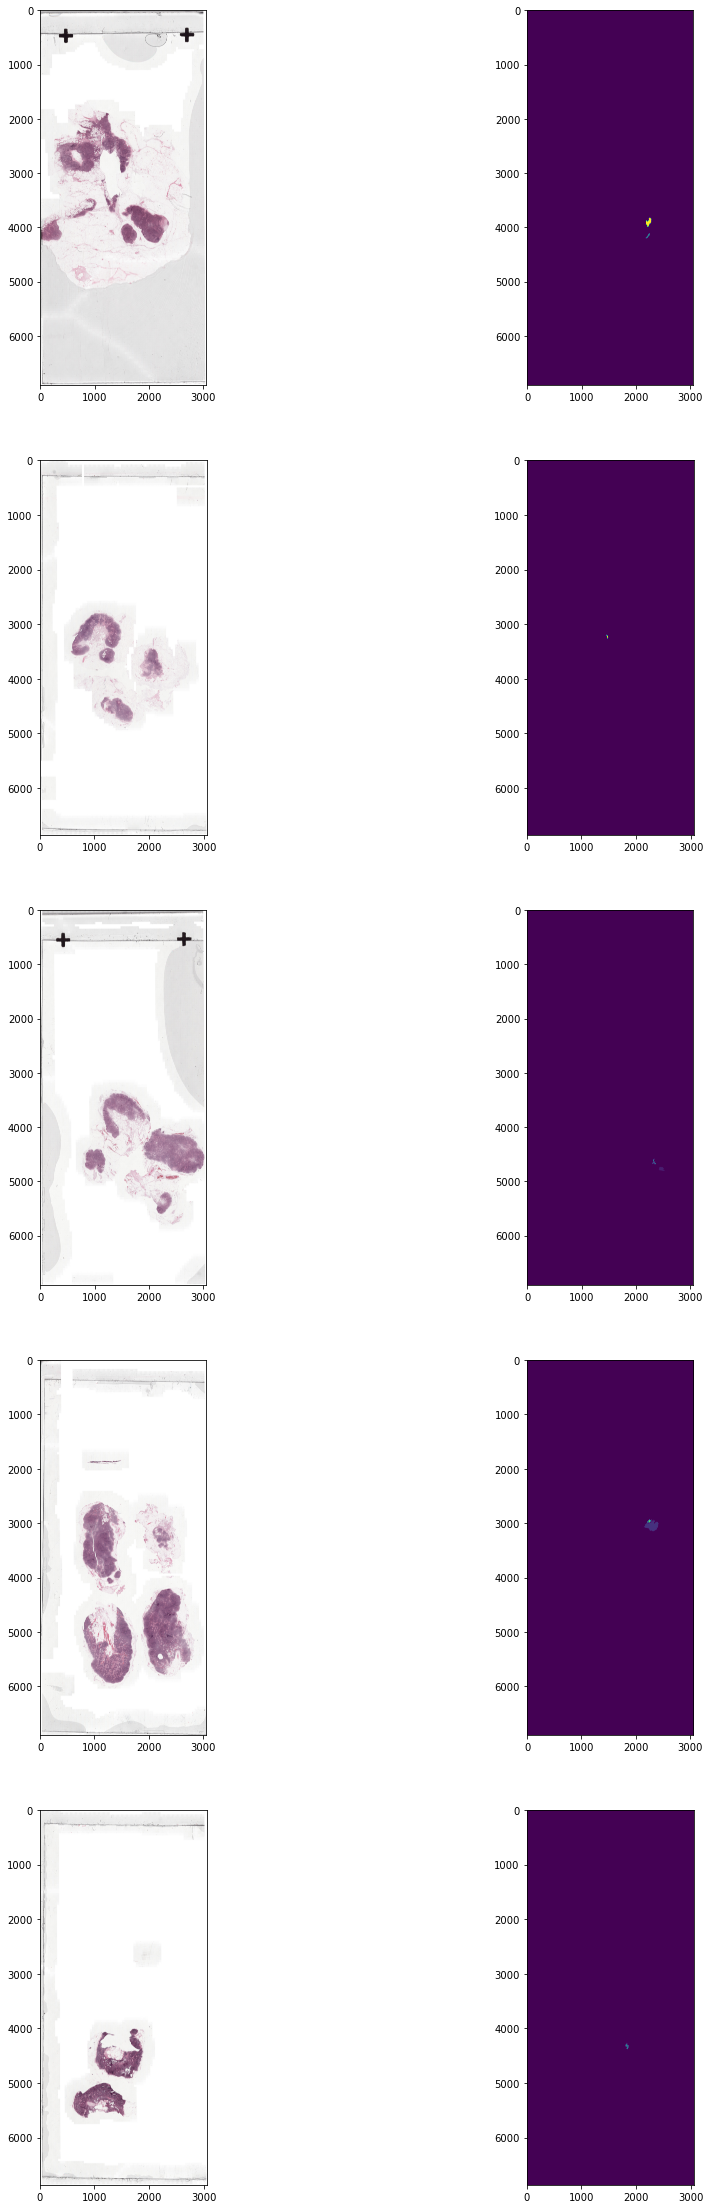

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

sample_paths = paths[:5]

num_rows = len(sample_paths)
num_cols = 2
f, ax_arr = plt.subplots(num_rows, num_cols, figsize=(16,8*num_rows))

for idx, (slide_path, output_path, annot_path) in enumerate(sample_paths):
    mask_img = Image.open(output_path)
    mask_img = Image.fromarray(np.array(mask_img, dtype=np.uint8) * 20)   
    with Slide(slide_path) as slide:
        slide_thumb = slide.get_thumbnail(5)
        slide_img = np_to_pil(slide_thumb)   
        # print(mask_img.size, np_to_pil(slide_thumb).size)
        ax_arr[idx][0].imshow(slide_img)
        ax_arr[idx][1].imshow(mask_img)

title = 'displaying images matrix'
plt.show()

In [7]:
import PIL

In [8]:
for idx, (x, y) in enumerate([(1,2), (3,4), (5,6)]):
    print(idx, x, y)

0 1 2
1 3 4
2 5 6
